Loaded data shape: (1000,)

Results:
--------------------------------------------------

Component 1:
Mean number of children (λ): 1.78
Proportion of families (π): 35.67%

Component 2:
Mean number of children (λ): 4.91
Proportion of families (π): 64.33%


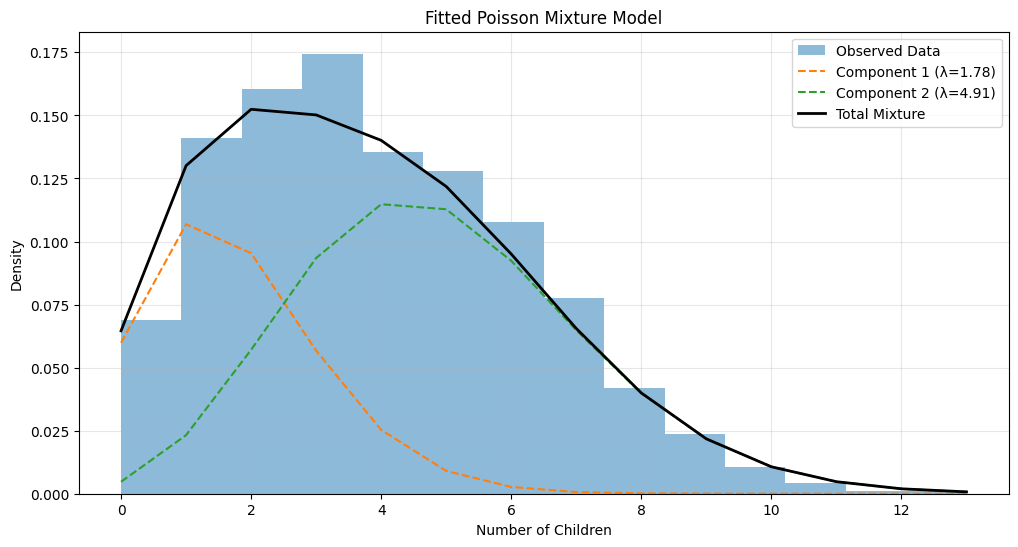

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

class PoissonMixtureEM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
        
        # Parameters to be estimated
        self.mixing_weights = None  # π (proportion of each component)
        self.rates = None          # λ (mean for each Poisson component)
        self.responsibilities = None  # γ (posterior probabilities)
        self.history = {'log_likelihood': [], 'rates': [], 'weights': []}
        
    def _poisson_pdf(self, x, rate):
        """Compute Poisson probability mass function"""
        return (rate ** x) * np.exp(-rate) / factorial(x)
    
    def _initialize_parameters(self, X):
        """Initialize mixing weights and rates"""
        self.mixing_weights = np.ones(self.n_components) / self.n_components
        
        # Initialize rates around the data mean
        mean_x = np.mean(X)
        self.rates = np.array([0.7 * mean_x, 1.3 * mean_x])
        
    def _e_step(self, X):
        """Expectation step: compute responsibilities"""
        weighted_likelihood = np.zeros((len(X), self.n_components))
        
        # Compute weighted likelihood for each component
        for k in range(self.n_components):
            weighted_likelihood[:, k] = self.mixing_weights[k] * \
                                      self._poisson_pdf(X, self.rates[k])
        
        # Compute responsibilities (posterior probabilities)
        total_likelihood = np.sum(weighted_likelihood, axis=1, keepdims=True)
        self.responsibilities = weighted_likelihood / total_likelihood
        
        # Compute log likelihood
        return np.sum(np.log(total_likelihood))
    
    def _m_step(self, X):
        """Maximization step: update parameters"""
        # Update mixing weights
        N = len(X)
        Nk = np.sum(self.responsibilities, axis=0)
        self.mixing_weights = Nk / N
        
        # Update rates
        for k in range(self.n_components):
            self.rates[k] = np.sum(self.responsibilities[:, k] * X) / Nk[k]
    
    def fit(self, X):
        """Fit the model to the data"""
        self._initialize_parameters(X)
        
        prev_log_likelihood = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step
            log_likelihood = self._e_step(X)
            
            # Store history
            self.history['log_likelihood'].append(log_likelihood)
            self.history['rates'].append(self.rates.copy())
            self.history['weights'].append(self.mixing_weights.copy())
            
            # Check convergence
            if np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
                
            # M-step
            self._m_step(X)
            prev_log_likelihood = log_likelihood
            
        return self
    
    def predict(self, X):
        """Predict component assignments"""
        weighted_likelihood = np.zeros((len(X), self.n_components))
        for k in range(self.n_components):
            weighted_likelihood[:, k] = self.mixing_weights[k] * \
                                      self._poisson_pdf(X, self.rates[k])
        return np.argmax(weighted_likelihood, axis=1)

def load_data(filename):
    """Load data from file"""
    return np.loadtxt(filename)

def plot_mixture_fit(X, model):
    """Plot the fitted mixture model"""
    plt.figure(figsize=(12, 6))
    
    # Plot histogram of actual data
    # Fix: Convert bins to integer and ensure it's positive
    n_bins = int(max(X) - min(X)) + 1
    plt.hist(X, bins=n_bins, density=True, alpha=0.5, 
             label='Observed Data')
    
    # Plot fitted components
    x_range = np.arange(min(X), max(X)+1)
    for k in range(model.n_components):
        component = model.mixing_weights[k] * \
                   model._poisson_pdf(x_range, model.rates[k])
        plt.plot(x_range, component, '--', 
                label=f'Component {k+1} (λ={model.rates[k]:.2f})')
    
    # Plot total mixture
    total_mixture = np.zeros_like(x_range, dtype=float)
    for k in range(model.n_components):
        total_mixture += model.mixing_weights[k] * \
                        model._poisson_pdf(x_range, model.rates[k])
    plt.plot(x_range, total_mixture, 'k-', linewidth=2, 
             label='Total Mixture')
    
    plt.title('Fitted Poisson Mixture Model')
    plt.xlabel('Number of Children')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    
def plot_convergence(model):
    """Plot convergence metrics"""
    plt.figure(figsize=(15, 5))
    
    # Plot log likelihood
    plt.subplot(131)
    plt.plot(model.history['log_likelihood'])
    plt.title('Log Likelihood Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    
    # Plot rate convergence
    plt.subplot(132)
    rates = np.array(model.history['rates'])
    for k in range(model.n_components):
        plt.plot(rates[:, k], label=f'Component {k+1}')
    plt.title('Rate (λ) Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Rate')
    plt.legend()
    
    # Plot mixing weights convergence
    plt.subplot(133)
    weights = np.array(model.history['weights'])
    for k in range(model.n_components):
        plt.plot(weights[:, k], label=f'Component {k+1}')
    plt.title('Mixing Weights (π) Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Weight')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load data
    data = load_data("em_data.txt")
    print(f"Loaded data shape: {data.shape}")
    
    # Fit model
    model = PoissonMixtureEM(n_components=2, max_iter=100, tol=1e-6)
    model.fit(data)
    
    # Print results
    print("\nResults:")
    print("-" * 50)
    for k in range(model.n_components):
        print(f"\nComponent {k+1}:")
        print(f"Mean number of children (λ): {model.rates[k]:.2f}")
        print(f"Proportion of families (π): {model.mixing_weights[k]:.2%}")
    
    # Create visualizations
    plot_mixture_fit(data, model)
    # plot_convergence(model)
    
    # # Additional analysis
    # assignments = model.predict(data)
    # print("\nComponent Assignments:")
    # print(f"Component 1: {np.sum(assignments == 0)} families")
    # print(f"Component 2: {np.sum(assignments == 1)} families")